##### PyMC3 Examples

# GLM Model Selection


**A fairly minimal reproducable example of Model Selection using DIC and WAIC.**

+ This example creates two toy datasets under linear and quadratic models, and then tests the fit of a range of polynomial linear models upon those datasets by using the Deviance Information Criterion (DIC) and Watanabe - Akaike (or Widest Available) Information Criterion (WAIC).
+ DIC (`stats.dic`) and WAIC (`stats.waic`) are new additions to PyMC3, so this example shows their usage in a more concrete fashion, also usage of the new `glm` submodule.
+ The example was inspired by Jake Vanderplas' [recent blogpost](https://jakevdp.github.io/blog/2015/08/07/frequentism-and-bayesianism-5-model-selection/) on model selection, although in this first iteration, Bayes Factor comparison is not implemented.
+ The datasets are tiny and generated within this Notebook. They contain errors in the measured value (y) only.


For more information on Model Selection in PyMC3, and about DIC and WAIC, you could start with:

+ Thomas Wiecki's [detailed response](https://stats.stackexchange.com/questions/161082/bayesian-model-selection-in-pymc3/166383#166383) to a question on Cross Validated
+ The Deviance Information Criterion: 12 Years On [(Speigelhalter et al 2014)](http://onlinelibrary.wiley.com/doi/10.1111/rssb.12062/abstract)
+ A Widely Applicable Bayesian Information Criterion [(Watanabe 2013)](http://www.jmlr.org/papers/volume14/watanabe13a/watanabe13a.pdf)
+ Efficient Implementation of Leave-One-Out Cross-Validation and WAIC for Evaluating Fitted Bayesian Models [(Gelman et al 2015)](http://arxiv.org/abs/1507.04544)



**Contents**

+ [Setup](#Setup)  
+ [Generate Toy Datasets](#Generate-Toy-Datasets)  
+ [Demonstrate Simple Linear Model](#Demonstrate-Simple-Linear-Model)
+ [Compare Higher-Order Linear Models](#Compare-Higher-Order-Linear-Models)
+ [Deviance Information Criterion (DIC)](#Deviance-Information-Criterion-(DIC))
+ [Watanabe-Akaike Information Criterion (WAIC)](#Watanabe-Akaike-Information-Criterion-(WAIC))



**Note:**

+ Python 3.4 project using latest available [PyMC3](https://github.com/pymc-devs/pymc3)
+ Developed using [ContinuumIO Anaconda](https://www.continuum.io/downloads) distribution on a Macbook Pro 3GHz i7, 16GB RAM, OSX 10.10.5.  
+ Finally, if runs become unstable or Theano throws weird errors, try clearing the cache `$> theano-cache clear` and rerunning the notebook.


**Package Requirements (shown as a conda-env YAML):**

```
$> less conda_env_pymc3_examples.yml

name: pymc3_examples
    channels:
      - defaults
    dependencies:
      - python=3.4
      - ipython
      - ipython-notebook
      - ipython-qtconsole
      - numpy
      - scipy
      - matplotlib
      - pandas
      - seaborn
      - patsy  
      - pip

$> conda env create --file conda_env_pymc3_examples.yml

$> source activate pymc3_examples

$> pip install --process-dependency-links git+https://github.com/pymc-devs/pymc3

```

# Setup

In [1]:
%matplotlib inline
%qtconsole --colors=linux

import warnings
warnings.filterwarnings('ignore')

In [2]:
from collections import OrderedDict
from time import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.optimize import fmin_powell
from scipy import integrate

import pymc3 as pm
import theano as thno
import theano.tensor as T 

from IPython.html.widgets import interactive, fixed

# configure some basic options
sns.set(style="darkgrid", palette="muted")
pd.set_option('display.notebook_repr_html', True)
plt.rcParams['figure.figsize'] = 12, 8
rndst = np.random.RandomState(0)

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Local Functions

In [3]:
def generate_data(n=20, p=0, a=1, b=1, c=0, latent_sigma_y=20):
    ''' 
    Create a toy dataset based on a very simple model that we might
    imagine is a noisy physical process:
        1. random x values within a range
        2. latent error aka inherent noise in y
        3. optionally create labelled outliers with larger noise

    Model form: y ~ a + bx + cx^2 + e
    
    NOTE: latent_sigma_y is used to create a normally distributed,
    'latent error' aka 'inherent noise' in the 'physical process' 
    generating thses values, rather than experimental measurement error. 
    Please don't use the returned `latent_error` values in inferential 
    models, it's returned in e dataframe for interest only.
    '''
    
    df = pd.DataFrame({'x':rndst.choice(np.arange(100),n,replace=False)})
                
    ## create linear or quadratic model
    df['y'] = a + b*(df['x']) + c*(df['x'])**2 

    ## create latent noise and marked outliers
    df['latent_error'] = rndst.normal(0,latent_sigma_y,n)
    df['outlier_error'] = rndst.normal(0,latent_sigma_y*10,n)
    df['outlier'] = rndst.binomial(1,p,n)
    
    ## add noise, with extreme noise for marked outliers
    df['y'] += ((1-df['outlier']) * df['latent_error'])
    df['y'] += (df['outlier'] * df['outlier_error'])
   
    ## round
    for col in ['y','latent_error','outlier_error','x']:
        df[col] = np.round(df[col],3)
       
    ## add label
    df['source'] = 'linear' if c == 0 else 'quadratic'
    
    ## create simple linspace for plotting true model
    plotx = np.linspace(df['x'].min() - np.ptp(df['x'])*.1
                        ,df['x'].max() + np.ptp(df['x'])*.1, 100)
    ploty = a + b*plotx + c*plotx**2
    dfp = pd.DataFrame({'x':plotx, 'y':ploty})
    
    return df, dfp
    

def interact_dataset(n=20, p=0, a=-30, b=5, c=0, latent_sigma_y=20):
    ''' 
    Convenience function:
    Interactively generate dataset and plot
    '''
    
    df, dfp = generate_data(n, p, a, b, c, latent_sigma_y)

    g = sns.FacetGrid(df, size=8, hue='outlier', hue_order=[True,False]
                    ,palette=sns.color_palette('Set1'), legend_out=False)

    _ = g.map(plt.errorbar, 'x', 'y', 'latent_error', marker="o"
              ,ms=10, mec='w', mew=2, ls='', elinewidth=0.7).add_legend()

    _ = plt.plot(dfp['x'], dfp['y'], '--', alpha=0.8)

    plt.subplots_adjust(top=0.92)
    _ = g.fig.suptitle('Sketch of Data Generation ({})'.format(df['source'][0])
                       ,fontsize=16)
        

def plot_datasets(df_lin, df_quad, dfp_lin, dfp_quad):
    '''
    Convenience function:
    Plot the two generated datasets in facets with generative model
    '''
    
    df = pd.concat((df_lin, df_quad), axis=0)
    dfp_lin, dfp_quad
   
    g = sns.FacetGrid(col='source', hue='source', data=df, size=6
                      ,sharey=False, legend_out=False)

    _ = g.map(plt.scatter, 'x', 'y', alpha=0.7, s=100, lw=2, edgecolor='w')

    _ = g.axes[0][0].plot(dfp_lin['x'], dfp_lin['y'], '--', alpha=0.6)
    _ = g.axes[0][1].plot(dfp_quad['x'], dfp_quad['y'], '--', alpha=0.6)
                
        
def plot_traces(traces, retain=1000):
    ''' 
    Convenience function:
    Plot traces with overlaid means and values
    '''
    
    ax = pm.traceplot(traces[-retain:], figsize=(12,len(traces.varnames)*1.5),
        lines={k: v['mean'] for k, v in pm.summary(traces[-retain:]).iterrows()})

    for i, mn in enumerate(pm.summary(traces[-retain:])['mean']):
        ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data'
                    ,xytext=(5,10), textcoords='offset points', rotation=90
                    ,va='bottom', fontsize='large', color='#AA0022')
    
    
def create_poly_modelspec(k=1):
    ''' 
    Convenience function:
    Create a polynomial modelspec string for patsy
    '''
    return ('y ~ 1 + x ' + ' '.join(['+ np.power(x,{})'.format(j) 
                                     for j in range(2,k+1)])).strip()


def run_models(df, upper_order=5):
    ''' 
    Convenience function:
    Fit a range of pymc3 models of increasing polynomial complexity. 
    Suggest limit to max order 5 since calculation time is exponential.
    '''
    
    models, traces = OrderedDict(), OrderedDict()

    for k in range(1,upper_order+1):

        nm = 'k{}'.format(k)
        fml = create_poly_modelspec(k)

        with pm.Model() as models[nm]:

            print('\nRunning: {}'.format(nm))
            pm.glm.glm(fml, df, family=pm.glm.families.Normal())

            start_MAP = pm.find_MAP(fmin=fmin_powell, disp=False)
            traces[nm] = pm.sample(2000, start=start_MAP, step=pm.NUTS(), progressbar=True) 
            
    return models, traces


def plot_posterior_cr(models, traces, rawdata, xlims,
                      datamodelnm='linear', modelnm='k1'):
    '''
    Convenience function:
    Plot posterior predictions with credible regions shown as filled areas.
    '''
    
    ## Get traces and calc posterior prediction for npoints in x
    npoints = 100
    mdl = models[modelnm]
    trc = pm.trace_to_dataframe(traces[modelnm][-1000:])
    trc = trc[[str(v) for v in mdl.cont_vars[:-1]]]

    ordr = int(modelnm[-1:])
    x = np.linspace(xlims[0], xlims[1], npoints).reshape((npoints,1))
    pwrs = np.ones((npoints,ordr+1)) * np.arange(ordr+1)
    X = x ** pwrs
    cr = np.dot(X,trc.T)

    ## Calculate credible regions and plot over the datapoints
    dfp = pd.DataFrame(np.percentile(cr,[2.5, 25, 50, 75, 97.5], axis=1).T
                         ,columns=['025','250','500','750','975'])
    dfp['x'] = x

    pal = sns.color_palette('Greens')
    f, ax1d = plt.subplots(1,1, figsize=(7,7))
    f.suptitle('Posterior Predictive Fit -- Data: {} -- Model: {}'.format(
                        datamodelnm, modelnm), fontsize=16)
    plt.subplots_adjust(top=0.95)

    ax1d.fill_between(dfp['x'], dfp['025'], dfp['975'], alpha=0.5
                      ,color=pal[1], label='CR 95%')
    ax1d.fill_between(dfp['x'], dfp['250'], dfp['750'], alpha=0.5
                      ,color=pal[4], label='CR 50%')
    ax1d.plot(dfp['x'], dfp['500'], alpha=0.6, color=pal[5], label='Median')
    _ = plt.legend()
    _ = ax1d.set_xlim(xlims)
    _ = sns.regplot(x='x', y='y', data=rawdata, fit_reg=False
                   ,scatter_kws={'alpha':0.7,'s':100, 'lw':2,'edgecolor':'w'}, ax=ax1d)


---

---

# Generate Toy Datasets

## Interactively Draft Data

Throughout the rest of the Notebook, we'll use two toy datasets created by a linear and a quadratic model respectively, so that we can better evaluate the fit of the model selection.

Right now, lets use an interactive session to play around with the data generation function in this Notebook, and get a feel for the possibilities of data we could generate.


$$y_{i} = a + bx_{i} + cx_{i}^{2} + \epsilon_{i}$$

where:  
$i \in n$ datapoints
$\epsilon \sim \mathcal{N}(0,latent\_sigma\_y)$


**NOTE on outliers:** 

+ We can use value `p` to set the (approximate) proportion of 'outliers' under a bernoulli distribution.
+ These outliers have a 10x larger `latent_sigma_y`
+ These outliers are labelled in the returned datasets and may be useful for other modelling, see another example Notebook `GLM-robust-with-outlier-detection.ipynb`

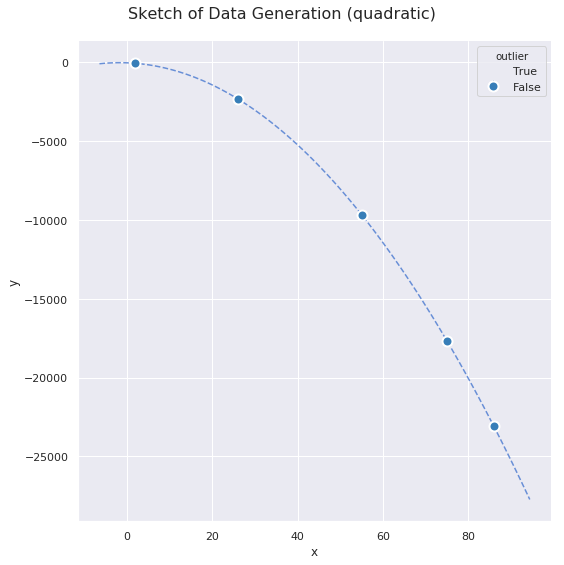

In [4]:
interactive(interact_dataset, n=[5,50,5], p=[0,.5,.05], a=[-50,50]
            ,b=[-10,10], c=[-3,3], latent_sigma_y=[0,1000,50])

**Observe:**

+ I've shown the `latent_error` in errorbars, but this is for interest only, since this shows the _inherent noise_ in whatever 'physical process' we imagine created the data.
+ There is no _measurement error_.
+ Datapoints created as outliers are shown in **red**, again for interest only.

## Create Datasets for Modelling

We can use the above interactive plot to get a feel for the effect of the params. Now we'll create 2 fixed datasets to use for the remainder of the Notebook. 

1. For a start, we'll create a linear model with small noise. Keep it simple.
2. Secondly, a quadratic model with small noise

In [5]:
n = 12
df_lin, dfp_lin = generate_data(n=n, p=0, a=-30, b=5, c=0, latent_sigma_y=40)
df_quad, dfp_quad = generate_data(n=n, p=0, a=-200, b=2, c=3, latent_sigma_y=500)

##### Scatterplot against model line

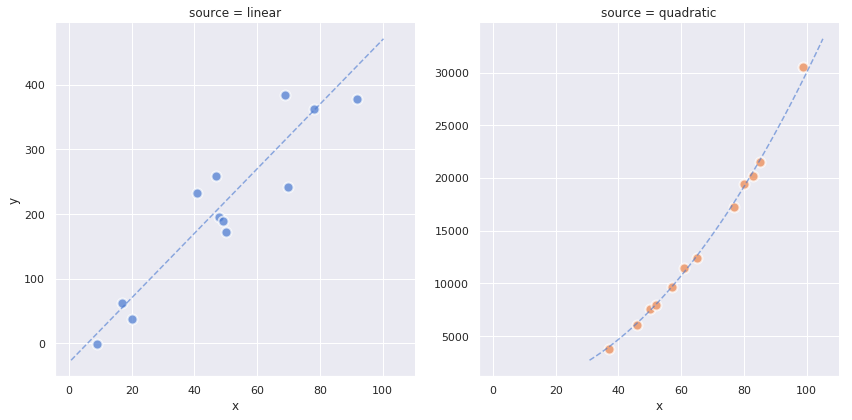

In [6]:
plot_datasets(df_lin, df_quad, dfp_lin, dfp_quad)

**Observe:**

+ We now have two datasets `df_lin` and `df_quad` created by a linear model and quadratic model respectively.
+ You can see this raw data, the ideal model fit and the effect of the latent noise in the scatterplots above
+ In the folowing plots in this Notebook, the linear-generated data will be shown in Blue and the quadratic in Green.


### Standardize

In [7]:
dfs_lin = df_lin.copy()
dfs_lin['x'] = (df_lin['x'] - df_lin['x'].mean()) / df_lin['x'].std()

dfs_quad = df_quad.copy()
dfs_quad['x'] = (df_quad['x'] - df_quad['x'].mean()) / df_quad['x'].std()

##### Create ranges for later ylim xim

In [8]:
dfs_lin_xlims = (dfs_lin['x'].min() - np.ptp(dfs_lin['x'])/10
                 ,dfs_lin['x'].max() + np.ptp(dfs_lin['x'])/10)

dfs_lin_ylims = (dfs_lin['y'].min() - np.ptp(dfs_lin['y'])/10
                 ,dfs_lin['y'].max() + np.ptp(dfs_lin['y'])/10)

dfs_quad_ylims = (dfs_quad['y'].min() - np.ptp(dfs_quad['y'])/10
                 ,dfs_quad['y'].max() + np.ptp(dfs_quad['y'])/10)

---

---

# Demonstrate Simple Linear Model

This *linear model* is really simple and conventional, an OLS with L2 constraints (Ridge Regression):

$$y = a + bx + \epsilon$$


## Define model using ordinary pymc3 method

In [9]:
with pm.Model() as mdl_ols:
        
    ## define Normal priors to give Ridge regression
    b0 = pm.Normal('b0', mu=0, sd=100)
    b1 = pm.Normal('b1', mu=0, sd=100)
 
    ## define Linear model
    yest = b0 + b1 * df_lin['x']

    ## define Normal likelihood with HalfCauchy noise (fat tails, equiv to HalfT 1DoF)
    sigma_y = pm.HalfCauchy('sigma_y', beta=10)
    likelihood = pm.Normal('likelihood', mu=yest, sd=sigma_y, observed=df_lin['y'])

    ## sample using NUTS (starting from MAP found using powell)
    start_MAP = pm.find_MAP(fmin=fmin_powell, disp=True)
    traces_ols = pm.sample(2000, start=start_MAP, step=pm.NUTS(), progressbar=True)

logp = -79.298:   5%|▌         | 260/5000 [00:00<00:00, 9608.69it/s]

Optimization terminated successfully.
         Current function value: 79.297349
         Iterations: 7
         Function evaluations: 266


logp = -79.298:   5%|▌         | 266/5000 [00:00<00:07, 672.46it/s] 
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_y, b1, b0]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:03<00:00, 2677.38draws/s]
The acceptance probability does not match the target. It is 0.8926649667329396, but should be close to 0.8. Try to increase the number of tuning steps.


##### View Traces after burn-in

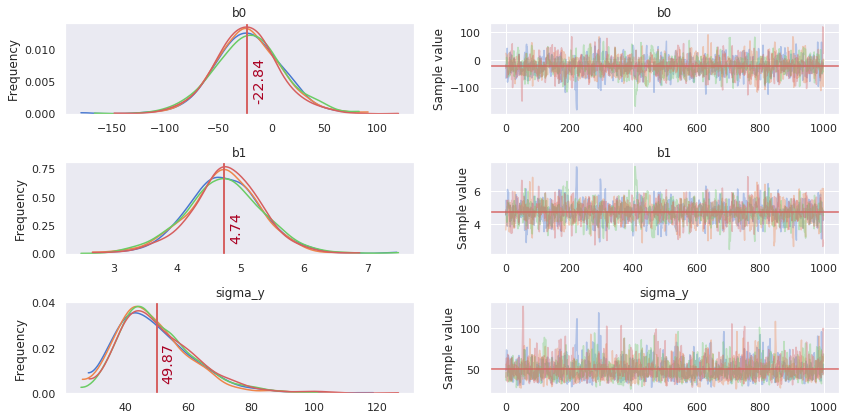

In [10]:
plot_traces(traces_ols, retain=1000)

**Observe:**

+ This simple OLS manages to make fairly good guesses on the model parameters - the data has been generated fairly simply after all - but it does appear to have been fooled slightly by the inherent noise.


## Define model using pymc3 GLM method

PyMC3 has a quite recently developed method - `glm` - for defining models using a `patsy`-style formula syntax. This seems really useful, especially for defining simple regression models in fewer lines of code. 

I couldn't find a direct comparison in the the examples, so before I launch into using `glm` for the rest of the Notebook, here's the same OLS model as above, defined using `glm`.

In [11]:
with pm.Model() as mdl_ols_glm:

    # setup model with Normal likelihood (which uses HalfCauchy for error prior)
    pm.glm.glm('y ~ 1 + x', df_lin, family=pm.glm.families.Normal())
    
    ## sample using NUTS (starting from MAP found using powell)
    start_MAP = pm.find_MAP(fmin=fmin_powell, disp=True)
    traces_ols_glm = pm.sample(2000, start=start_MAP, step=pm.NUTS(), progressbar=True)

AttributeError: module 'pymc3.glm' has no attribute 'glm'

##### View Traces after burn-in

In [ ]:
plot_traces(traces_ols_glm, retain=1000)

**Observe:**

+ The output parameters are of course named differently to the custom naming before. Now we have:

    `b0 == Intercept`  
    `b1 == x`  
    `sigma_y_log == sd_log`  
    `sigma_y == sd`  
    
    
+ However, naming aside, this `glm`-defined model appears to behave in a very similar way, and finds the same parameter values as the conventionally-defined model - any differences are due to the random nature of the sampling.
+ We can quite happily use the `glm` syntax for further models below, since it allows us to create a small model factory very easily.

---

---

# Compare Higher-Order Linear Models

Back to the real purpose of this Notebook: demonstrate model selection.

First, let's create and run a set of polynomial models on each of our toy datasets. By default this is for models of order 1 to 5.

## Create and run polynomial models

In [ ]:
models_lin, traces_lin = run_models(dfs_lin, 5)

In [ ]:
models_quad, traces_quad = run_models(dfs_quad, 5)

## Really bad model selection: compare likelihoods

##### Evaluate log likelihoods straight from model.logp

In [ ]:
dfll = pd.DataFrame(index=['k1','k2','k3','k4','k5'], columns=['lin','quad'])
dfll.index.name = 'model'

for nm in dfll.index:
    dfll.loc[nm,'lin'] =-models_lin[nm].logp(pm.df_summary(traces_lin[nm])['mean'].to_dict())
    dfll.loc[nm,'quad'] =-models_quad[nm].logp(pm.df_summary(traces_quad[nm])['mean'].to_dict())

dfll = pd.melt(dfll.reset_index(), id_vars=['model'], var_name='poly'
               ,value_name='log_likelihood')

##### Plot log-likelihoods

In [ ]:
g = sns.factorplot(x='model', y='log_likelihood', col='poly', hue='poly'
                   ,data=dfll, kind='bar', size=6)

**Observe:**

+ For both datsets, the linear-generated (lhs) and the quadratic-generated (rhs)

## View posterior predictive fit

In [ ]:
interactive(plot_posterior_cr, models=fixed(models_lin), traces=fixed(traces_lin)
            ,rawdata=fixed(dfs_lin), xlims=fixed(dfs_lin_xlims), datamodelnm=fixed('linear')
            ,modelnm = ['k1','k2','k3','k4','k5'])

---

# Compare Deviance Information Criterion (DIC)

##### Manual way, probably error-prone

In [ ]:
dftrc_lin = pm.trace_to_dataframe(traces_lin['k1'])
trc_lin_logp = dftrc_lin.apply(lambda x: models_lin['k1'].logp(x.to_dict()), axis=1)
mean_deviance = -2 * trc_lin_logp.mean(0)
mean_deviance

In [ ]:
deviance_at_mean = -2 * models_lin['k1'].logp(dftrc_lin.mean(0).to_dict())
deviance_at_mean

In [ ]:
dic_k1 = 2 * mean_deviance - deviance_at_mean
dic_k1

##### Or we could use the newly created function in `stats.py`, much better!

In [ ]:
pm.stats.dic(model=models_lin['k1'], trace=traces_lin['k1'])

##### Lets loop through all the models and calculate the DIC

In [ ]:
dfdic = pd.DataFrame(index=['k1','k2','k3','k4','k5'], columns=['lin','quad'])
dfdic.index.name = 'model'

for nm in dfdic.index:
    dfdic.loc[nm, 'lin'] = pm.stats.dic(traces_lin[nm],models_lin[nm])
    dfdic.loc[nm, 'quad'] = pm.stats.dic(traces_quad[nm],models_quad[nm])

dfdic = pd.melt(dfdic.reset_index(), id_vars=['model'], var_name='poly', value_name='dic')

g = sns.factorplot(x='model', y='dic', col='poly', hue='poly', data=dfdic, kind='bar', size=6)

**Observe**

+ Linear-generated data (lhs):
    + The DIC increases monotonically with model complexity, this is great too see!
    + The more complicated the model, the more it would appear we are overfitting.


+ Quadratic-generated data (rhs):
    + The DIC dips slightly for the correct model k2
    + The difference is slight though!


+ We should prefer the model(s) with lower DIC, which (happily) directly opposes the increasing likelihood we saw earlier. 

---

---

# Watanabe - Akaike Information Criterion (WAIC)

aka Widely Applicable Information Criterion

##### This time go straight for the implementation in pymc3

In [ ]:
pm.stats.waic(model=models_lin['k1'], trace=traces_lin['k1'])

In [ ]:
dfwaic = pd.DataFrame(index=['k1','k2','k3','k4','k5'], columns=['lin','quad'])
dfwaic.index.name = 'model'

for nm in dfwaic.index:
    dfwaic.loc[nm, 'lin'] = pm.stats.waic(traces_lin[nm],models_lin[nm])
    dfwaic.loc[nm, 'quad'] = pm.stats.waic(traces_quad[nm],models_quad[nm])

dfwaic = pd.melt(dfwaic.reset_index(), id_vars=['model'], var_name='poly', value_name='waic')

g = sns.factorplot(x='model', y='waic', col='poly', hue='poly', data=dfwaic, kind='bar', size=6)

**Observe**

+ We should prefer the model(s) with lower WAIC

+ Linear-generated data (lhs):
    + The WAIC seems quite flat across models

+ Quadratic-generated data (rhs):
    + The WAIC is certainly wrong for k1, but otherwise also quite flat. Dips in the right place at k2


---

---

# TODO

## K-Fold Cross Validation and Leave-One-Out (LOO)

##### Left for future development - should be easy enough

http://www.stat.columbia.edu/~gelman/research/unpublished/waic_stan.pdf

## Bayes Factor

##### Will be left for future development - scipy only useful for 2D and 3D. Beyond that, dragons.

Following text lifted directly from [JakeVDP blogpost](https://jakevdp.github.io/blog/2015/08/07/frequentism-and-bayesianism-5-model-selection/)

The Bayesian approach proceeds very differently. Recall that the Bayesian model involves computing the odds ratio between two models:

$$O_{21}=\frac{P(M_{2} \;|\; D)}{P(M_{1} \;|\; D)}=\frac{P(D \;|\; M_{2})}{P(D \;|\; M_{1})}\frac{P(M_{2})}{P(M_{1})}$$

Here the ratio $\frac{P(M2)}{P(M1)}$ is the prior odds ratio, and is often assumed to be equal to 1 if no compelling prior evidence favors one model over another. The ratio $\frac{P(D \;|\; M2)}{P(D \;|\; M1)}$ is the **Bayes factor**, and is the key to Bayesian model selection.


The Bayes factor can be computed by evaluating the integral over the parameter likelihood:

$$P(D \;|\; M)=\int_{\Omega}P(D \;|\; \theta,M) \; P(\theta \;|\; M) \;d\theta$$

This integral is over the entire parameter space of the model, and thus can be extremely computationally intensive, especially as the dimension of the model grows beyond a few. 

---

Example originally contributed by Jonathan Sedar 2016-01-04 [github.com/jonsedar](https://github.com/jonsedar)